In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal, GlorotNormal
import random
import seaborn as sns

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(54000, 28, 28)
(10000, 28, 28)
(54000,)
(10000,)


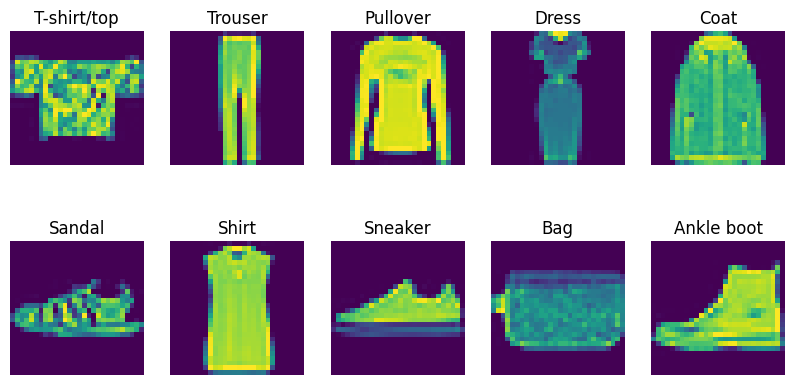

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig,axes = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
  ax = axes[i//5 , i % 5]
  idx = np.where(y_train == i)[0][0]
  ax.imshow(x_train[idx])
  ax.set_title(class_names[i])
  ax.axis('off')
plt.show()

In [9]:
hyperparameter_combinations = [
    (5, [32, 32, 32], 0.0005, 1e-3, 'adam', 32, 'xavier', 'relu'),
    (10, [64, 64, 64, 64], 0, 1e-4, 'sgd', 16, 'random', 'sigmoid'),
    (5, [128, 128, 128, 128, 128], 0.5, 1e-3, 'rmsprop', 64, 'xavier', 'relu'),
    (10, [32, 32, 32], 0.0005, 1e-4, 'nadam', 32, 'random', 'sigmoid'),
    (5, [64, 64, 64, 64], 0, 1e-3, 'nesterov', 16, 'xavier', 'relu'),
    (10, [128, 128, 128, 128, 128], 0.5, 1e-4, 'momentum', 64, 'random', 'sigmoid'),
    (5, [32, 32, 32], 0.0005, 1e-3, 'sgd', 32, 'xavier', 'relu'),
    (10, [64, 64, 64, 64], 0, 1e-4, 'adam', 16, 'random', 'sigmoid'),
    (5, [128, 128, 128, 128, 128], 0.5, 1e-3, 'rmsprop', 64, 'xavier', 'relu'),
    (10, [32, 32, 32], 0.0005, 1e-4, 'nadam', 32, 'random', 'sigmoid'),
    (10, [128, 128, 128, 128, 128], 0.0005, 1e-3, 'adam', 32, 'xavier', 'relu'),
    (5, [64, 64, 64], 0, 1e-3, 'rmsprop', 16, 'random', 'relu'),
    (10, [64, 64, 64, 64], 0.0005, 1e-4, 'nadam', 32, 'xavier', 'relu'),
    (5, [128, 128, 128, 128, 128], 0, 1e-3, 'sgd', 64, 'random', 'sigmoid'),
    (10, [32, 32, 32], 0.5, 1e-4, 'momentum', 32, 'xavier', 'relu'),
    (5, [64, 64, 64], 0, 1e-3, 'nesterov', 16, 'random', 'relu')
]

In [10]:
def create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate, weight_init):
    initializer = RandomNormal() if weight_init == 'random' else GlorotNormal()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))  # Flatten the input image

    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units=units, activation=activation,
                                        kernel_regularizer=l2(weight_decay),
                                        kernel_initializer=initializer))

    model.add(tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=initializer))  # Output layer
    if optimizer in ['momentum', 'nesterov']:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=(optimizer == 'nesterov'))
    else:
      if isinstance(optimizer, str):
        optimizer = tf.keras.optimizers.get({'class_name': optimizer, 'config': {'learning_rate': learning_rate}})
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [11]:
results = []

for i, (num_epochs, hidden_layers, weight_decay, learning_rate, optimizer, batch_size, weight_init, activation) in enumerate(hyperparameter_combinations):
    print(f"\nTraining Model {i+1}/{len(hyperparameter_combinations)} with {optimizer}, {activation}, batch size {batch_size}...")

    model = create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate, weight_init)

    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    results.append({
        'Model': i+1,
        'Epochs': num_epochs,
        'Hidden Layers': hidden_layers,
        'Weight Decay': weight_decay,
        'Learning Rate': learning_rate,
        'Optimizer': optimizer,
        'Batch Size': batch_size,
        'Weight Init': weight_init,
        'Activation': activation,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc
    })


Training Model 1/16 with adam, relu, batch size 32...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7039 - loss: 0.8824 - val_accuracy: 0.8392 - val_loss: 0.5164
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8435 - loss: 0.4907 - val_accuracy: 0.8407 - val_loss: 0.4878
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8565 - loss: 0.4561 - val_accuracy: 0.8588 - val_loss: 0.4464
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8650 - loss: 0.4371 - val_accuracy: 0.8658 - val_loss: 0.4291
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8690 - loss: 0.4276 - val_accuracy: 0.8722 - val_loss: 0.4288

Training Model 2/16 with sgd, sigmoid, batch size 16...
Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1010 - loss: 2.3088 - val_accuracy: 0.1013 - val_loss: 2.3046
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0994 - loss: 2.3045 - val_accuracy: 0.1013 - val_loss: 2.3031
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━

In [12]:
df_results = pd.DataFrame(results)
print(df_results)

    Model  Epochs              Hidden Layers  Weight Decay  Learning Rate  \
0       1       5               [32, 32, 32]        0.0005         0.0010   
1       2      10           [64, 64, 64, 64]        0.0000         0.0001   
2       3       5  [128, 128, 128, 128, 128]        0.5000         0.0010   
3       4      10               [32, 32, 32]        0.0005         0.0001   
4       5       5           [64, 64, 64, 64]        0.0000         0.0010   
5       6      10  [128, 128, 128, 128, 128]        0.5000         0.0001   
6       7       5               [32, 32, 32]        0.0005         0.0010   
7       8      10           [64, 64, 64, 64]        0.0000         0.0001   
8       9       5  [128, 128, 128, 128, 128]        0.5000         0.0010   
9      10      10               [32, 32, 32]        0.0005         0.0001   
10     11      10  [128, 128, 128, 128, 128]        0.0005         0.0010   
11     12       5               [64, 64, 64]        0.0000         0.0010   

In [13]:
best_model_config = df_results.loc[df_results["Validation Accuracy"].idxmax()]
print("Best Model Configuration:")
print(best_model_config)

Best Model Configuration:
Model                             1
Epochs                            5
Hidden Layers          [32, 32, 32]
Weight Decay                 0.0005
Learning Rate                 0.001
Optimizer                      adam
Batch Size                       32
Weight Init                  xavier
Activation                     relu
Validation Accuracy        0.872167
Test Accuracy                0.8605
Name: 0, dtype: object


In [14]:
num_epochs = best_model_config["Epochs"]
hidden_layers = best_model_config["Hidden Layers"]
weight_decay = best_model_config["Weight Decay"]
learning_rate = best_model_config["Learning Rate"]
optimizer = best_model_config["Optimizer"]
batch_size = best_model_config["Batch Size"]
weight_init = best_model_config["Weight Init"]
activation = best_model_config["Activation"]

# Retrain the best model using full training set (train + val)
best_model = create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate, weight_init)

# Train the model on the entire training dataset (train + validation)
best_model.fit(np.vstack([x_train, x_val]), np.hstack([y_train, y_val]),
               epochs=num_epochs, batch_size=batch_size, verbose=1)

# Evaluate on test set
test_loss_ce, test_acc_ce = best_model.evaluate(x_test, y_test, verbose=1)

print(f"Best Model Test Accuracy (Cross Entropy Loss): {test_acc_ce:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7203 - loss: 0.8458
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8505 - loss: 0.4799
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8610 - loss: 0.4524
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8665 - loss: 0.4316
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8701 - loss: 0.4227
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8532 - loss: 0.4765
Best Model Test Accuracy (Cross Entropy Loss): 0.8524


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


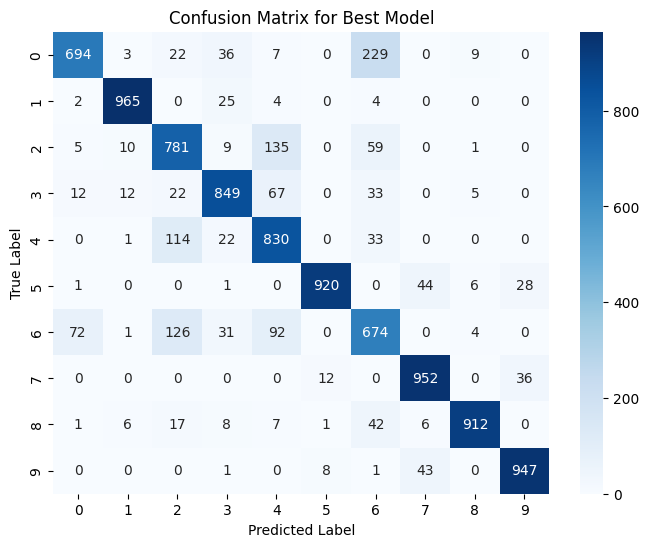

In [15]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(best_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


In [16]:
if optimizer in ['momentum', 'nesterov']:
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=(optimizer == 'nesterov'))
else:
  optimizer = optimizer
best_model_mse = create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate, weight_init)

#As the dimensions are different one hot encoding is done
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_train_val_onehot = np.vstack([y_train_onehot, y_val_onehot])
best_model_mse.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['accuracy'])
best_model_mse.fit(np.vstack([x_train, x_val]), y_train_val_onehot,
                   epochs=num_epochs, batch_size=batch_size, verbose=1)
test_loss_mse, test_acc_mse = best_model_mse.evaluate(x_test, tf.keras.utils.to_categorical(y_test, num_classes=10), verbose=1)

print(f"Best Model Test Accuracy (Squared Error Loss): {test_acc_mse:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7237 - loss: 0.0675
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8087 - loss: 0.0407
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8190 - loss: 0.0372
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8236 - loss: 0.0355
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8261 - loss: 0.0343
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7923 - loss: 0.0368
Best Model Test Accuracy (Squared Error Loss): 0.7917


In [17]:
print(f"Test Accuracy with Cross-Entropy Loss: {test_acc_ce:.4f}")
print(f"Test Accuracy with Squared Error Loss: {test_acc_mse:.4f}")

# Compare the loss values
print(f"Test Loss with Cross-Entropy: {test_loss_ce:.4f}")
print(f"Test Loss with Squared Error: {test_loss_mse:.4f}")


Test Accuracy with Cross-Entropy Loss: 0.8524
Test Accuracy with Squared Error Loss: 0.7917
Test Loss with Cross-Entropy: 0.4748
Test Loss with Squared Error: 0.0371



Training Model 1 - adam, [128, 128, 128, 128, 128] layers
Epoch 1/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7467 - loss: 0.9540 - val_accuracy: 0.8013 - val_loss: 0.7210
Epoch 2/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8428 - loss: 0.6056 - val_accuracy: 0.8463 - val_loss: 0.5633
Epoch 3/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8578 - loss: 0.5254 - val_accuracy: 0.8378 - val_loss: 0.5652
Epoch 4/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8633 - loss: 0.4954 - val_accuracy: 0.8504 - val_loss: 0.4951
Epoch 5/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8723 - loss: 0.4595 - val_accuracy: 0.8643 - val_loss: 0.4739
Epoch 6/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8707 - loss: 0.4556 - val_accuracy: 0.8656 - val_loss: 0.4657
Epoch 7/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8758 - loss: 0.4351 - val_accuracy: 0.8685 - val_loss: 0.4695
Epoch 8/10
1519/1519 ━━━━━━━━

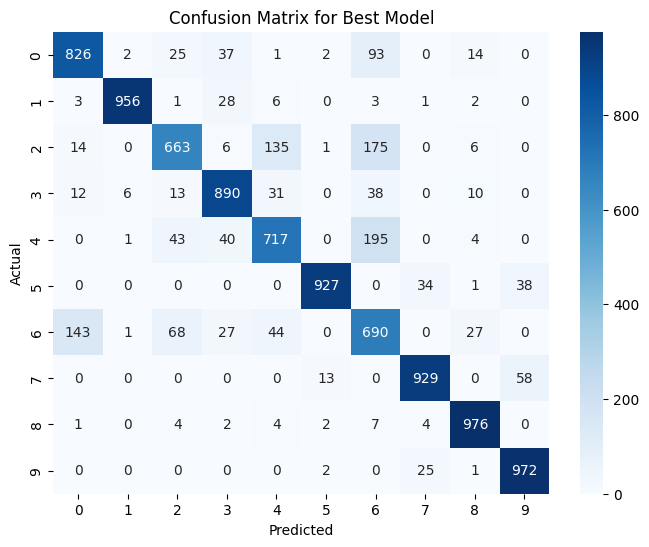

In [18]:
# Recommended hyperparameter configurations
hyperparameter_combinations = [
    (10, [128, 128, 128, 128, 128], 0.0005, 1e-3, 'adam', 32, 'xavier', 'relu'),
    (5, [64, 64, 64], 0, 1e-3, 'rmsprop', 16, 'random', 'relu'),
    (10, [64, 64, 64, 64], 0.0005, 1e-4, 'nadam', 32, 'xavier', 'relu')
]

for i, (epochs, hidden_layers, weight_decay, learning_rate, optimizer, batch_size, weight_init, activation) in enumerate(hyperparameter_combinations):
    print(f"\nTraining Model {i+1} - {optimizer}, {hidden_layers} layers")

    model = create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate, weight_init)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
    # Save best model
    if i == 0:
        best_model = model

# Confusion Matrix for Best Model
y_pred = np.argmax(best_model.predict(x_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Model')
plt.show()



In [19]:
best_model_mse = create_model([128, 128, 128, 128, 128], 'relu', 'adam', 0.0005, 1e-3, 'xavier')
best_model_mse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mean_squared_error", metrics=['accuracy'])
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)
best_model_mse.fit(x_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
test_loss_mse, test_acc_mse = best_model_mse.evaluate(x_test, y_test_onehot, verbose=1)
print(f"\nTest Accuracy (Squared Error Loss): {test_acc_mse:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6777 - loss: 0.1205 - val_accuracy: 0.7956 - val_loss: 0.0462
Epoch 2/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7913 - loss: 0.0452 - val_accuracy: 0.7857 - val_loss: 0.0450
Epoch 3/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8042 - loss: 0.0414 - val_accuracy: 0.8119 - val_loss: 0.0398
Epoch 4/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8103 - loss: 0.0395 - val_accuracy: 0.8143 - val_loss: 0.0389
Epoch 5/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8176 - loss: 0.0381 - val_accuracy: 0.8017 - val_loss: 0.0397
Epoch 6/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8194 - loss: 0.0373 - val_accuracy: 0.7852 - val_loss: 0.0412
Epoch 7/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8267 - loss: 0.0363 - val_accuracy: 0.8302 - val_loss: 0.0359
Epoch 8/10
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8273 - loss: 0.0359 -